In [1]:
import pandas as pd
import numpy as np
from scipy import  linalg
from sklearn.decomposition import  PCA
import  matplotlib.pyplot as plt
import  itertools
from sklearn.cluster import KMeans
import colorsys


In [2]:
cname = ['VendorID','pckdt','dpdt','png_cnt',\
         'trp_dist','pck_lng','pck_lat','rcid','store_and_fwd_flags',\
         'dp_lng','dp_lat' ,'payment_type','fr_amnt','extra','mta_tax',
         'tip_amnt','tll_amnt','srchrg','tt_aamnt']
ltype = {'VendorID': int,'pckdt':str,'dpdt':str,'png_cnt': int,\
         'trp_dist':float,'pck_lng': float,'pck_lat': float,'rcid':int,'store_and_fwd_flags':str,\
         'dp_lng':float,'dp_lat':float ,'payment_type':int,'fr_amnt':float,'extra':float,'mta_tax':float,
         'tip_amnt':float,'tll_amnt':float,'srchrg':float,'tt_aamnt':float}

In [3]:
data_feb_yellow = pd.read_csv('yellow_tripdata_2015-02.csv',parse_dates = ['tpep_pickup_datetime','tpep_dropoff_datetime'])

In [4]:

data_feb_yellow.columns = cname


# Find trips that delivered between 10am to 4pm

In [6]:
time_diff = data_feb_yellow['dpdt'] - data_feb_yellow['pckdt']
test = [ sec.seconds for sec in time_diff ]
time_diff_flt = np.array(test)

In [7]:
y1 = data_feb_yellow['pckdt'].dt.hour>19 
y2 = data_feb_yellow['pckdt'].dt.hour<23
y = y1*y2

# Pick lat and lng associated with these night trips 

In [8]:
ngt_lat = np.array(data_feb_yellow['pck_lat'])

In [9]:
ngt_lng = np.array(data_feb_yellow['pck_lng'])

In [10]:
cry1 =ngt_lat >40.5
cry2 =ngt_lat <41.0
cry4 =ngt_lng >-74.2
cry5 =ngt_lng <-73.7
cry3 = cry1*cry2*cry4*cry5*y


In [11]:
data_feb_yellow.loc[:, 'ngt_crt_ind'] = np.array(cry3)

In [12]:
ngt_data_frame_crt = data_feb_yellow[data_feb_yellow['ngt_crt_ind']> 0]

In [14]:

ngt_sample_frame = ngt_data_frame_crt.loc[np.random.choice(ngt_data_frame_crt.index, 20000,replace=False)]

# Try clustering on the night rides to find the centriods 

In [15]:
N_clst = 22
random_state = 200
ngt_km = KMeans(n_clusters=N_clst, random_state=random_state)

In [16]:
X = ngt_sample_frame[['pck_lng','pck_lat']]
X = np.array(X)
ngt_km.fit_predict(X)
k_means_labels = ngt_km.labels_
k_means_cluster_centers = ngt_km.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

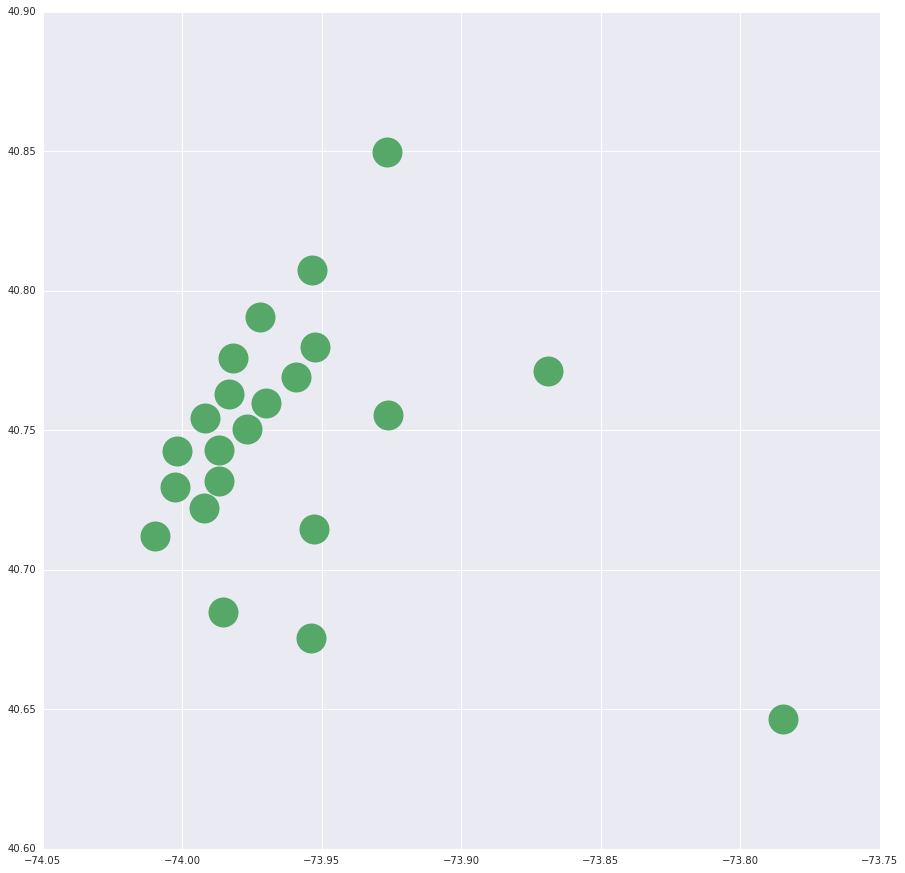

In [163]:
#%matplotlib inline
#plt.figure(figsize = (15,15))
#plt.xlim([-74.05,-73.75])
#plt.plot(ngt_sample_frame['pck_lng'],ngt_sample_frame['pck_lat'],'+', k_means_cluster_centers[:,0],k_means_cluster_centers[:,1],'o',markersize=30)


In [17]:
y_pred = ngt_km.predict(ngt_data_frame_crt[['pck_lng','pck_lat']])
y_count = [sum(y_pred == i) for i in range(N_clst)]


# Calculat metric = <(fare+tip)/time>_rides*(num of ride)

In [32]:
metric =  (np.array(ngt_data_frame_crt['fr_amnt']) + np.array(ngt_data_frame_crt['tip_amnt'])) /(1+time_diff_flt[np.array(cry3)>0])  
metric_val = []
for i in range(N_clst):
    metric_val.append( np.mean(metric[y_pred == i])*y_count[i])

metric_val = np.array(metric_val)
metric_val = metric_val.reshape((len(metric_val),1))
metric_val_cent = np.concatenate((metric_val,k_means_cluster_centers), axis=1)
metric_val_cent.shape
metric_val_cent = metric_val_cent[np.argsort(metric_val_cent[:,0])]


# Plot figure

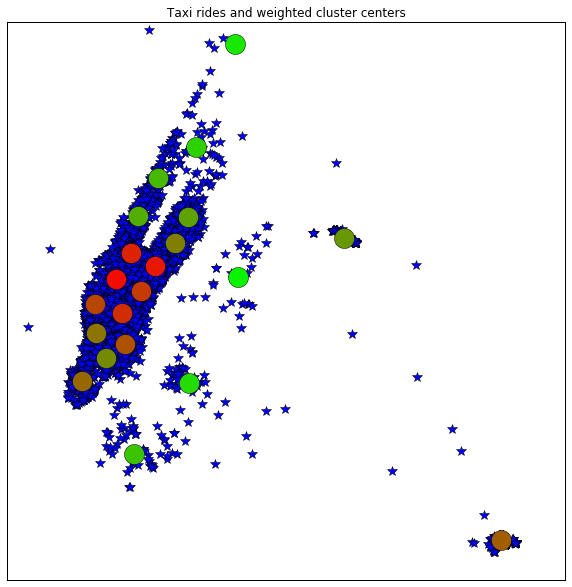

In [36]:
%matplotlib inline
N = 22
HSV_tuples = [(x*1.0/N, 0.5, 1.0) for x in range(N)]
RGB_tuples  = [(x*1.0/N, 1- x*1.0/N, 0.0) for x in range(N)]#= map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)

fig = plt.figure(figsize=(10, 10))
plt.xlim([-74.05,-73.75])
plt.ylim([40.63,40.86])
fig.patch.set_alpha(0.0)
ax = fig.add_subplot(1, 1, 1)
ax.plot(ngt_sample_frame['pck_lng'],ngt_sample_frame['pck_lat'],'*',markerfacecolor='b',  markersize=10)

for k,col in zip(range(N_clst),RGB_tuples):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(metric_val_cent[k,1], metric_val_cent[k,2], 'o', markerfacecolor=col,\
             markeredgecolor='k', markersize=20)
ax.set_title('Taxi rides and weighted cluster centers')
ax.set_xticks(())
ax.set_yticks(())
fig.savefig('fig1.png')

-74.00555419921875